## Step 1. Import libraries

In [25]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math 
import copy
import pickle
import gc

from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.base import clone

from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Step 1. Load and explore the data

In [26]:
TARGET = 'Response'
SEED = 94

In [27]:
print('Loading Data...')
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

print('Data Load Successfully.')

Loading Data...
Data Load Successfully.


In [28]:
train.shape, test.shape

((11504798, 12), (7669866, 11))

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [30]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.752398e+06,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,3.321149e+06,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.876199e+06,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,5.752398e+06,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,8.628598e+06,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.150480e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [31]:
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1


In [32]:
#Combine daataset for processing
train['is_train'] = 1
test['is_train'] = 0

df = pd.concat([train, test])
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0.0,1
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1.0,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0.0,1
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0.0,1
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0.0,1


## Step 2. Data preprocessing

In [33]:
# Check missing values
df.isnull().sum()

id                            0
Gender                        0
Age                           0
Driving_License               0
Region_Code                   0
Previously_Insured            0
Vehicle_Age                   0
Vehicle_Damage                0
Annual_Premium                0
Policy_Sales_Channel          0
Vintage                       0
Response                7669866
is_train                      0
dtype: int64

* **Age and Vehicle_Age (0.77)**:
    Strong positive correlation. Older individuals tend to have older vehicles.
* **Previously_Insured and Vehicle_Damage (-0.84)**:
    Strong negative correlation. If someone is previously insured, their vehicle is less likely to be damaged.
* **Policy_Sales_Channel and Age (-0.60)**:
    Moderate negative correlation. Younger individuals are more likely to be reached through certain sales channels.

In [37]:
def transform_categorical_features(df):
    print('Transforming categorical features..')

    gender_map = {'Male': 0, 'Female': 1}
    vehicle_age = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2} 
    vehicle_damage = {'No':0, 'Yes':1}

    df['Gender'] = df['Gender'].map(gender_map)
    df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age)
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map(vehicle_damage)

    print("Transformed successfully.")
    return df

def create_additional_features(df):
    print('Creating additional features..')
    
    df['VA_PSC'] = pd.factorize(df['Vehicle_Age'].astype(str) + df['Policy_Sales_Channel'].astype(str))[0]
    df['A_VA'] = pd.factorize(df['Age'].astype(str) + df['Vehicle_Age'].astype(str))[0]
    df['PI_VD'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vehicle_Damage'].astype(str))[0]
    df['PI_V'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vintage'].astype(str))[0]
    df['PSC_A'] = pd.factorize(df['Policy_Sales_Channel'].astype(str) + df['Age'].astype(str))[0]

    return df

def adjust_data_types(df):
    print('Adjusting data types')
    df['Region_Code'] = df['Region_Code'].astype(int)
    df['Annual_Premium'] = df['Annual_Premium'].astype(int)
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)
    
    return df

def optimize_memory_usage(df):
    print('Optimizing memory usage')
    start_mem_usage = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type.name in ['category', 'object']:
            raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)

    end_mem_usage = df.memory_usage().sum() / 1024**2
    print(f'------ Memory usage before: {start_mem_usage:.2f} MB')
    print(f'------ Memory usage after: {end_mem_usage:.2f} MB')
    print(f'------ Reduced memory usage by {(100 * (start_mem_usage - end_mem_usage) / start_mem_usage):.1f}%')

    return df

def scale_features(df, features_to_scale):
    print('Scaling features...')
    min_max_scaler = MinMaxScaler()
    df[features_to_scale] = min_max_scaler.fit_transform(df[features_to_scale])
    print('Features scaled successfully.')
    return df

In [39]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0.0,1
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1.0,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0.0,1
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0.0,1
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0.0,1


In [40]:
df = transform_categorical_features(df)
df = adjust_data_types(df)  
df = create_additional_features(df)
df = optimize_memory_usage(df)                      

Transforming categorical features..
Transformed successfully.
Adjusting data types
Creating additional features..
Optimizing memory usage
------ Memory usage before: 2560.09 MB
------ Memory usage after: 713.17 MB
------ Reduced memory usage by 72.1%


In [41]:
features_to_scale = [ 'Annual_Premium', 'Vintage', 'Policy_Sales_Channel']
df = scale_features(df, features_to_scale)

df.head()    

Scaling features...
Features scaled successfully.


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,VA_PSC,A_VA,PI_VD,PI_V,PSC_A
0,0,0,21,1,35,0,1,1,0.116218,0.759259,0.612457,0.0,1,0,0,0,0,0
1,1,0,43,1,28,0,2,1,0.104702,0.154321,0.961938,1.0,1,1,1,0,1,1
2,2,1,25,1,14,1,0,0,0.065880,0.932099,0.844291,0.0,1,2,2,1,2,2
3,3,1,35,1,1,0,1,1,0.000000,0.956790,0.228374,0.0,1,3,3,0,3,3
4,4,1,36,1,15,1,1,0,0.054547,0.932099,0.982699,0.0,1,4,4,1,4,4


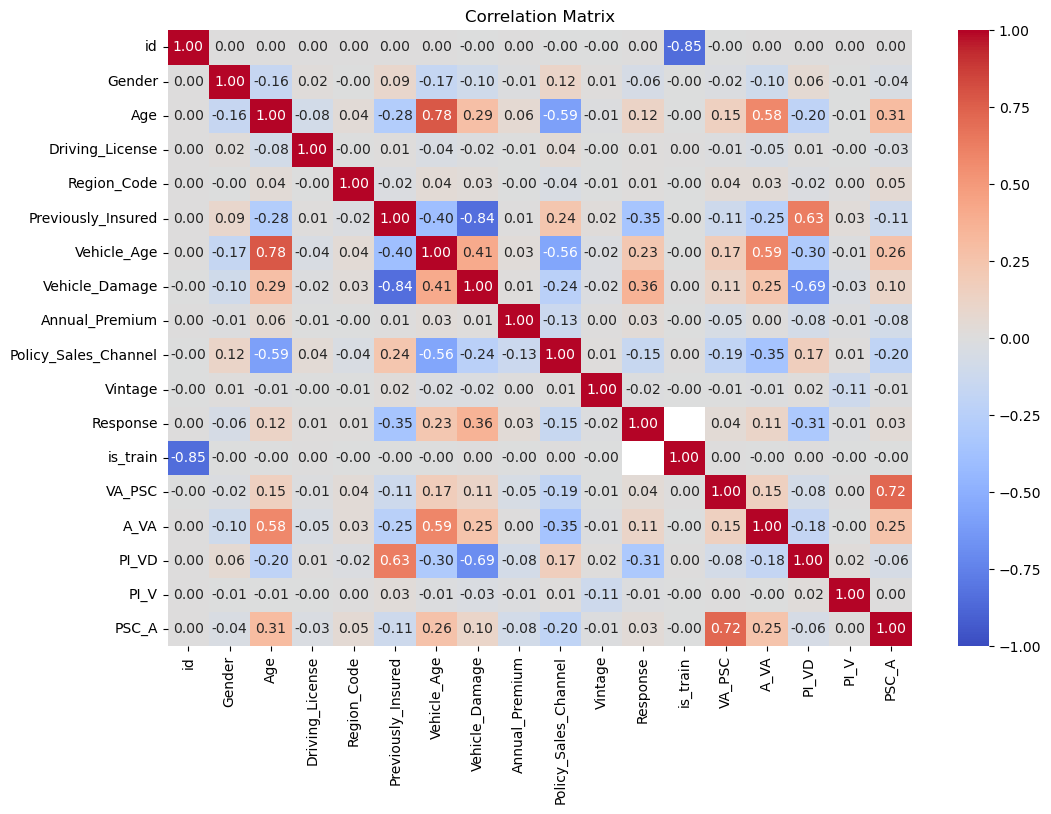

In [18]:
# Compute the correlation matrix
corr = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

### Add polinomial features

In [42]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


## Step 4. Split the data

In [43]:
# Split the data back into train and test sets
train = df[df['is_train'] == 1].drop(columns=['is_train'])
test = df[df['is_train'] == 0].drop(columns=['is_train'])

X_train = train.drop(columns=[TARGET])
y_train = train[TARGET]

X_test = test.drop(columns=[TARGET])

### Subsample the data to speed up training process

In [45]:

X_train_subsample = X_train.sample(frac=0.1, random_state=42)
y_train_subsample = y_train.sample(frac=0.1, random_state=42)


## Step 5. Train the model LightGBM

In [86]:
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss

def train_and_evaluate(model, X, y, X_test, folds=5, random_state=None):
    print(f'Training {model.__class__.__name__}\n')
    
    scores = []
    feature_importances = np.zeros(X.shape[1])
    evaluation_history = []
    
    oof_pred_probs = np.zeros(X.shape[0])
    test_pred_probs = np.zeros(X_test.shape[0])
    
    skf = StratifiedKFold(n_splits=folds, random_state=random_state, shuffle=True)
    
    for fold_index, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model_clone = copy.deepcopy(model)
        model_clone.fit(
            X_train, 
            y_train, 
            eval_set=[(X_val, y_val)],
            eval_metric = 'AUC'  # Set the evaluation metric here
        )
        
        feature_importances += model_clone.feature_importances_ / folds
        evaluation_history.append(model_clone.evals_result_)
        
        y_pred_probs = model_clone.predict_proba(X_val)[:, 1]
        oof_pred_probs[val_index] = y_pred_probs
        
        temp_test_pred_probs = model_clone.predict_proba(X_test)[:, 1]
        test_pred_probs += temp_test_pred_probs / folds
        
        auc_score = roc_auc_score(y_val, y_pred_probs)
        
        log_loss_score = log_loss(y_val, y_pred_probs)
        print("Log Loss:", log_loss_score)

        scores.append(auc_score)
        
        print(f'\n--- Fold {fold_index + 1} - AUC: {auc_score:.5f}\n\n')
        
        del model_clone
        gc.collect()
    
    print(f'------ Average AUC: {np.mean(scores):.5f} ± {np.std(scores):.5f}\n\n')

    return oof_pred_probs, test_pred_probs, feature_importances, evaluation_history


In [ ]:
# Example best parameters for LightGBM
best_params = {
    'max_depth': -1,
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'num_leaves': 31,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'early_stopping_rounds': 50,
    'verbose': 1
}

best_lgbm_model = LGBMClassifier(**best_params, random_state=94)

# Call train_and_evaluate function with LGBMClassifier model
oof_pred_probs, predictions, feature_importances, evaluation_history = train_and_evaluate(best_lgbm_model, X_train, y_train, X_test, folds=10, random_state=94)

Training LGBMClassifier

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 1273553, number of negative: 9080765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.331567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1869
[LightGBM] [Info] Number of data points in the train set: 10354318, number of used features: 16
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122997 -> initscore=-1.964348
[LightGBM] [Info] Start training from score -1.964348
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's auc: 0.880947	v

In [74]:
submission = pd.DataFrame({
    'id': X_test['id'],
    'Response': predictions
})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,Response
0,11504798,0.018863
1,11504799,0.442534
2,11504800,0.250040
3,11504801,0.000180
4,11504802,0.068477


In [79]:
print(oof_pred_probs[50])

0.3385182421912732


In [80]:
print(predictions[50])

0.0002249025819795229


In [85]:
print(feature_importances)

[10922.7  1471.2 10487.6   255.4 10685.6   780.4  1983.   1053.  14126.7
  8030.1 18414.   6214.9  7762.7  1173.9 15356.6  8894.2]


## Step 6. Evaluation 

In [ ]:
from sklearn.metrics import log_loss

# Assuming y_test and y_pred are continuous values between 0 and 1
log_loss_score = log_loss(y_test.to_numpy()[:,1], y_pred['Response'])
print("Log Loss:", log_loss_score)

## Possible improvements

1. Hyperparameters tuning using RandomSearch
2. More data preproccessing

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import lightgbm as lgb

# Define the parameter grid
param_dist = {
    'max_depth': randint(3, 15),  # Example range: 3 to 15
    'learning_rate': uniform(0.01, 0.2),  # Example range: 0.01 to 0.21
    'n_estimators': randint(100, 10000),  # Example range: 100 to 10000
    'num_leaves': randint(20, 150),  # Example range: 20 to 150
    'colsample_bytree': uniform(0.6, 0.4),  # Example range: 0.6 to 1.0
    'subsample': uniform(0.6, 0.4),  # Example range: 0.6 to 1.0
    'reg_alpha': uniform(0.0, 1.0),  # Example range: 0.0 to 1.0
    'reg_lambda': uniform(0.0, 1.0),  # Example range: 0.0 to 1.0
    'min_split_gain': uniform(0.0, 0.2),  # Example range: 0.0 to 0.2
    'min_child_weight': randint(1, 50)  # Example range: 1 to 50
}

# Initialize the LGBMClassifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=100,  # Adjust the number of iterations based on computational resources
    scoring='roc_auc',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Assuming X_train_subsample and y_train_subsample are already defined
random_search.fit(X_train_subsample, y_train_subsample)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best AUC found: ", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
# Split the full training set into train and validation sets for final training
X_train_full, X_val, y_train_full, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Train on the full training data using the best hyperparameters with early stopping on validation set
best_params = random_search.best_params_
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='auc', random_state=42)

best_model.fit(X_train_full, y_train_full, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=100)

# Evaluate on the separate test set
y_pred_probs = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_probs)
print(f'Test AUC: {auc_score:.5f}')